In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch
import torch.nn as nn

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

print("Imports OK ✅")

Imports OK ✅


## Load and Prepare Data


In [12]:
# Load data
filename = "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/NB6 - Gradient Descent/Fraud_detection.csv"
df = pd.read_csv(filename)
df_clean = df.dropna()

print(f"Dataset shape: {df_clean.shape}")
print(f"Class distribution:\n{df_clean['target'].value_counts()}")
df_clean.head()

Dataset shape: (164492, 30)
Class distribution:
target
0    162391
1      2101
Name: count, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
0,-5.387212,4.184541,-1.532484,-1.965818,-2.281421,-0.811241,-1.622605,2.584704,1.691805,2.446557,...,-0.186285,-0.438230,0.446793,-0.057267,0.284110,0.798562,0.871452,0.624266,0.77,0
1,1.191628,-0.241745,1.267706,-0.389685,-1.387590,-1.073890,-0.625846,-0.162185,3.037995,-1.462181,...,-0.118968,0.136868,0.029872,0.886954,0.408935,-0.759999,0.066885,0.036600,11.85,0
2,-0.320070,0.817292,-0.383529,-0.308166,2.602632,3.476013,0.275237,0.873423,-0.674953,0.023649,...,0.072037,0.179752,-0.137884,1.002022,-0.024809,-0.302421,0.410612,0.221219,28.71,0
3,-0.425102,0.986576,1.447792,-0.225688,0.128470,-0.389236,0.580774,0.112083,-0.604489,-0.136107,...,-0.201610,-0.557063,-0.078498,-0.020800,-0.187823,0.074749,0.260763,0.106826,0.89,0
4,1.121653,0.489337,0.511771,2.330934,0.092104,0.165210,-0.001065,0.165187,-0.955771,0.853500,...,0.077408,0.171815,-0.027943,0.002375,0.442279,0.051457,-0.008672,0.003507,0.00,0


In [13]:
# Prepare features and target
X = df_clean.drop(columns=["target"]).values
y = df_clean["target"].values

# Identify the amount column
if "Amount" in df_clean.columns:
    AMOUNT_COL = "Amount"
elif "amount" in df_clean.columns:
    AMOUNT_COL = "amount"
else:
    # Fallback: try to find the first numeric column that isn't the target
    cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if "target" in cols:
        cols.remove("target")
    AMOUNT_COL = cols[0]

print(f"Using '{AMOUNT_COL}' as the transaction amount column.")
amounts = df_clean[AMOUNT_COL].values

# Split data: 60% train, 20% validation, 20% test (including amounts)
X_tr, X_tmp, y_tr, y_tmp, amt_tr, amt_tmp = train_test_split(
    X, y, amounts, test_size=0.4, random_state=42, stratify=y
)
X_va, X_te, y_va, y_te, amt_va, amt_te = train_test_split(
    X_tmp, y_tmp, amt_tmp, test_size=0.5, random_state=43, stratify=y_tmp
)

print(f"Train set: {X_tr.shape}")
print(f"Val set:   {X_va.shape}")
print(f"Test set:  {X_te.shape}")
print(f"Amount arrays: train={len(amt_tr)}, val={len(amt_va)}, test={len(amt_te)}")

Using 'Amount' as the transaction amount column.
Train set: (98695, 29)
Val set:   (32898, 29)
Test set:  (32899, 29)
Amount arrays: train=98695, val=32898, test=32899


## Evaluation Function with Threshold Optimization


In [14]:
def evaluate_model_with_threshold_sweep(
    model,
    X_te,
    y_te,
    amounts_te=None,
    model_type="sklearn",
    model_name="Model",
    abandonment_rate=0.2,
    max_abandonment_ratio=0.1,
    auth_fee_per_request=1,
    abandonment_penalty=10000,
    n_thresholds=1000,
    plot=True,
):
    """
    Evaluate a classification model with threshold optimization for custom cost function.

    Parameters:
    -----------
    model : trained model
        The trained classification model to evaluate
    X_te : array-like
        Test features
    y_te : array-like
        Test labels
    amounts_te : array-like, optional
        Transaction amounts for calculating missed fraud costs. If None, uses sum of features.
    model_type : str, default="sklearn"
        Type of model: "sklearn" or "pytorch"
    model_name : str, default="Model"
        Name of the model for display purposes
    abandonment_rate : float, default=0.2
        Rate at which users abandon when authentication is requested
    max_abandonment_ratio : float, default=0.1
        Maximum allowed abandonment ratio before penalty applies
    auth_fee_per_request : float, default=1
        Cost per authentication request (€)
    abandonment_penalty : float, default=10000
        Penalty per abandonment above threshold (€)
    n_thresholds : int, default=100
        Number of thresholds to test
    plot : bool, default=True
        Whether to generate visualization plots

    Returns:
    --------
    dict : Dictionary containing optimal threshold, predictions, and results dataframe
    """

    # Get probability scores
    if model_type == "sklearn":
        proba = model.predict_proba(X_te)[:, 1]
    elif model_type == "pytorch":
        model.eval()
        with torch.no_grad():
            X_te_tensor = torch.tensor(X_te, dtype=torch.float32)
            logits = model(X_te_tensor)
            proba = torch.softmax(logits, dim=1)[:, 1].numpy()
    else:
        raise ValueError("model_type must be 'sklearn' or 'pytorch'")

    # Test different thresholds
    thresholds = np.linspace(0, 1, n_thresholds)
    results = []

    for threshold in thresholds:
        preds = (proba >= threshold).astype(int)

        # Calculate metrics
        total_transactions = len(y_te)
        authentication_requested = (preds == 1).sum()

        # Calculate abandonment ratio
        abandonment_count = abandonment_rate * authentication_requested
        abandonment_ratio = abandonment_count / total_transactions

        # Only consider if we don't exceed max abandonment ratio
        if abandonment_ratio <= max_abandonment_ratio:
            # Calculate costs
            missed_frauds_indices = np.where((preds == 0) & (y_te == 1))[0]
            # Use transaction amounts if provided, otherwise fall back to sum of features
            if amounts_te is not None:
                missed_frauds_cost = amounts_te[missed_frauds_indices].sum()
            else:
                missed_frauds_cost = X_te[missed_frauds_indices].sum()
            authentication_fee = authentication_requested * auth_fee_per_request
            abandonment_cost = abandonment_penalty * max(
                0, abandonment_ratio - max_abandonment_ratio
            )
            total_cost = missed_frauds_cost + authentication_fee + abandonment_cost

            # Calculate performance metrics
            precision = precision_score(y_te, preds, zero_division=0)
            recall = recall_score(y_te, preds, zero_division=0)
            f1 = f1_score(y_te, preds, zero_division=0)
            accuracy = accuracy_score(y_te, preds)

            results.append(
                {
                    "threshold": threshold,
                    "total_cost": total_cost,
                    "auth_requested": authentication_requested,
                    "abandonment_ratio": abandonment_ratio,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "accuracy": accuracy,
                    "missed_frauds_cost": missed_frauds_cost,
                    "auth_fee": authentication_fee,
                    "abandonment_cost": abandonment_cost,
                }
            )

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    if len(results_df) == 0:
        print(
            f"⚠️  No valid thresholds found for {model_name} (all exceed abandonment limit)"
        )
        return None

    # Find optimal threshold
    best_idx = results_df["total_cost"].idxmin()
    best_result = results_df.iloc[best_idx]

    # Print results
    print("=" * 70)
    print(f"{model_name.upper()} - OPTIMAL THRESHOLD RESULTS")
    print("=" * 70)
    print(f"Best threshold: {best_result['threshold']:.3f}")
    print(f"\nTotal cost: €{best_result['total_cost']:.2f}")
    print(f"Authentication requested: {int(best_result['auth_requested'])}")
    print(
        f"Abandonment ratio: {best_result['abandonment_ratio']:.4f} ({best_result['abandonment_ratio']*100:.2f}%)"
    )
    print(f"\nPerformance Metrics:")
    print(f"  Precision: {best_result['precision']:.4f}")
    print(f"  Recall:    {best_result['recall']:.4f}")
    print(f"  F1 Score:  {best_result['f1']:.4f}")
    print(f"  Accuracy:  {best_result['accuracy']:.4f}")
    print(f"\nCost Breakdown:")
    print(f"  Missed frauds cost:   €{best_result['missed_frauds_cost']:.2f}")
    print(f"  Authentication fee:   €{best_result['auth_fee']:.2f}")
    print(f"  Abandonment penalty:  €{best_result['abandonment_cost']:.2f}")
    print("=" * 70)

    # Generate plots
    if plot:
        fig = plt.figure(figsize=(14, 10))
        fig.suptitle(
            f"{model_name} - Threshold Optimization Analysis",
            fontsize=16,
            fontweight="bold",
        )

        # Plot 1: Total Cost vs Threshold
        plt.subplot(2, 2, 1)
        plt.plot(
            results_df["threshold"],
            results_df["total_cost"],
            linewidth=2,
            color="#2E86AB",
        )
        plt.axvline(
            best_result["threshold"],
            color="red",
            linestyle="--",
            label=f'Optimal: {best_result["threshold"]:.3f}',
            linewidth=2,
        )
        plt.xlabel("Threshold", fontsize=11)
        plt.ylabel("Total Cost (€)", fontsize=11)
        plt.title("Total Cost vs Threshold", fontsize=12, fontweight="bold")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Authentication Requests vs Threshold
        plt.subplot(2, 2, 2)
        plt.plot(
            results_df["threshold"],
            results_df["auth_requested"],
            linewidth=2,
            color="#A23B72",
        )
        plt.axvline(best_result["threshold"], color="red", linestyle="--", linewidth=2)
        plt.axhline(
            len(y_te) * max_abandonment_ratio / abandonment_rate,
            color="orange",
            linestyle=":",
            label=f"Max auth ({max_abandonment_ratio*100:.0f}% abandonment)",
            linewidth=2,
        )
        plt.xlabel("Threshold", fontsize=11)
        plt.ylabel("Authentication Requests", fontsize=11)
        plt.title(
            "Authentication Requests vs Threshold", fontsize=12, fontweight="bold"
        )
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 3: Abandonment Ratio vs Threshold
        plt.subplot(2, 2, 3)
        plt.plot(
            results_df["threshold"],
            results_df["abandonment_ratio"],
            linewidth=2,
            color="#F18F01",
        )
        plt.axvline(best_result["threshold"], color="red", linestyle="--", linewidth=2)
        plt.axhline(
            max_abandonment_ratio,
            color="orange",
            linestyle=":",
            label=f"{max_abandonment_ratio*100:.0f}% limit",
            linewidth=2,
        )
        plt.xlabel("Threshold", fontsize=11)
        plt.ylabel("Abandonment Ratio", fontsize=11)
        plt.title("Abandonment Ratio vs Threshold", fontsize=12, fontweight="bold")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 4: Performance Metrics vs Threshold
        plt.subplot(2, 2, 4)
        plt.plot(
            results_df["threshold"],
            results_df["precision"],
            label="Precision",
            linewidth=2,
        )
        plt.plot(
            results_df["threshold"], results_df["recall"], label="Recall", linewidth=2
        )
        plt.plot(results_df["threshold"], results_df["f1"], label="F1", linewidth=2)
        plt.axvline(best_result["threshold"], color="red", linestyle="--", linewidth=2)
        plt.xlabel("Threshold", fontsize=11)
        plt.ylabel("Score", fontsize=11)
        plt.title("Performance Metrics vs Threshold", fontsize=12, fontweight="bold")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Get optimal predictions
    optimal_preds = (proba >= best_result["threshold"]).astype(int)

    return {
        "optimal_threshold": best_result["threshold"],
        "optimal_predictions": optimal_preds,
        "results_df": results_df,
        "best_result": best_result,
        "probabilities": proba,
    }

## Model Definitions and Training Functions


In [15]:
# Define PyTorch Neural Network Architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)


def train_pytorch_model(
    X_tr, y_tr, X_va, y_va, hidden_dim=32, lr=1e-3, epochs=50, batch_size=64
):
    """Train a PyTorch neural network model."""
    # Convert to tensors
    X_train_t = torch.tensor(X_tr, dtype=torch.float32)
    y_train_t = torch.tensor(y_tr, dtype=torch.long)
    X_val_t = torch.tensor(X_va, dtype=torch.float32)
    y_val_t = torch.tensor(y_va, dtype=torch.long)

    # Initialize model
    model = SimpleNN(X_tr.shape[1], hidden_dim)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_weights = None
    N = X_train_t.shape[0]

    print(
        f"Training Neural Network (hidden_dim={hidden_dim}, lr={lr}, epochs={epochs})..."
    )

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]

            logits = model(xb)
            loss = loss_fn(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / N

        # Validation accuracy
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_preds = torch.argmax(val_logits, dim=1)
            val_acc = (val_preds == y_val_t).float().mean().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = {
                k: v.detach().clone() for k, v in model.state_dict().items()
            }

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1:02d}/{epochs}  loss={avg_loss:.4f}  val_acc={val_acc:.4f}"
            )

    # Restore best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)

    print(f"✅ Training complete. Best validation accuracy: {best_val_acc:.4f}\n")
    return model

## Test Different Models


### 1. Logistic Regression


Training Logistic Regression...
✅ Training complete

✅ Training complete

LOGISTIC REGRESSION - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.006

Total cost: €32083.47
Authentication requested: 15149
Abandonment ratio: 0.0921 (9.21%)

Performance Metrics:
  Precision: 0.0246
  Recall:    0.8857
  F1 Score:  0.0478
  Accuracy:  0.5494

Cost Breakdown:
  Missed frauds cost:   €16934.47
  Authentication fee:   €15149.00
  Abandonment penalty:  €0.00
LOGISTIC REGRESSION - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.006

Total cost: €32083.47
Authentication requested: 15149
Abandonment ratio: 0.0921 (9.21%)

Performance Metrics:
  Precision: 0.0246
  Recall:    0.8857
  F1 Score:  0.0478
  Accuracy:  0.5494

Cost Breakdown:
  Missed frauds cost:   €16934.47
  Authentication fee:   €15149.00
  Abandonment penalty:  €0.00


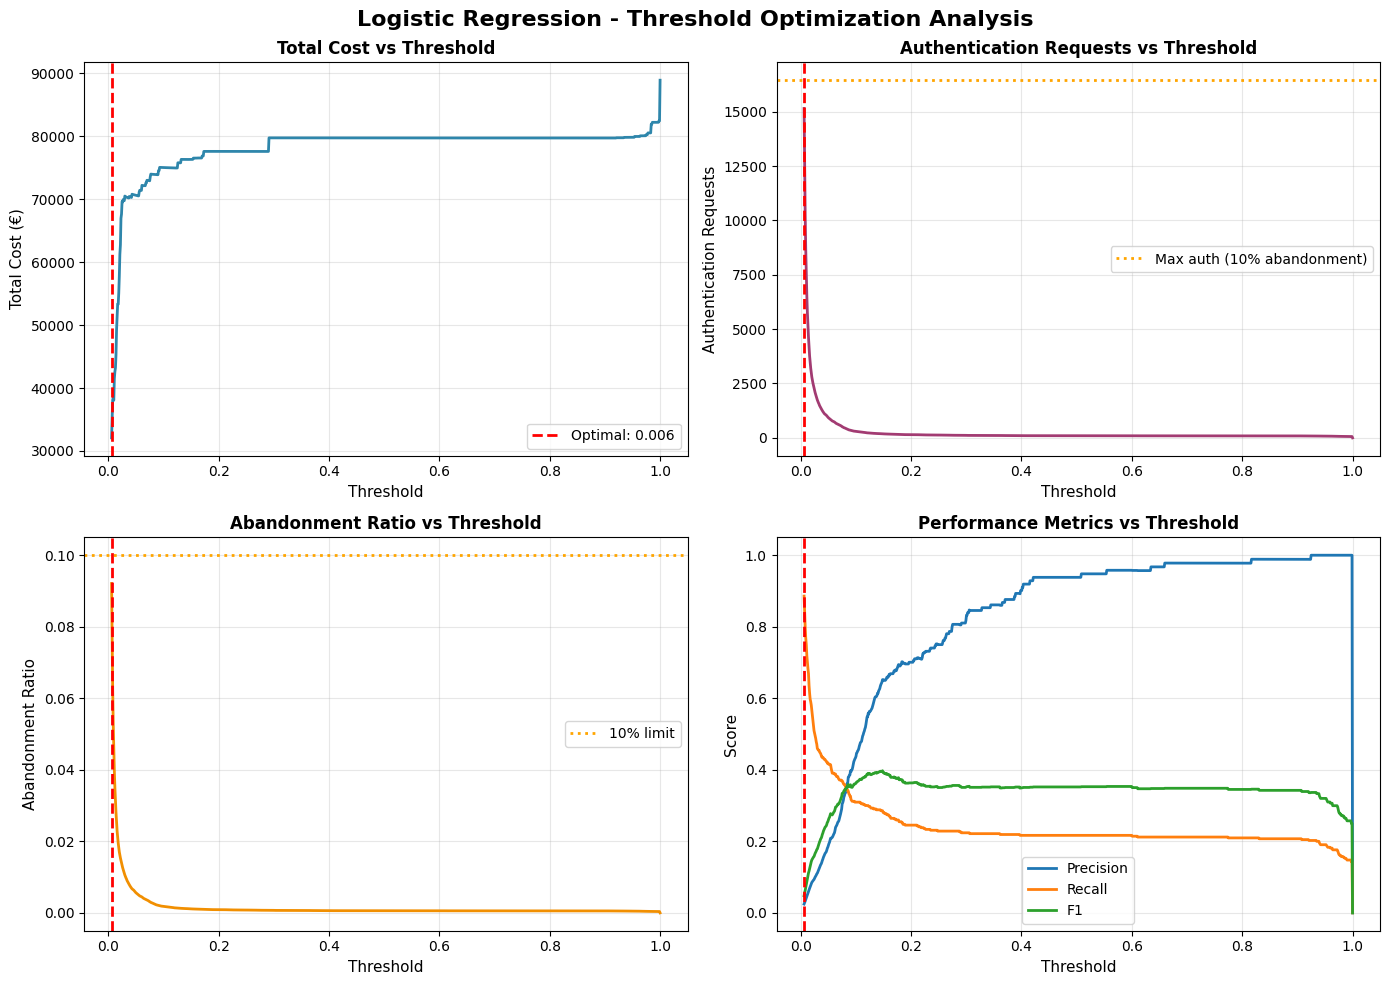

In [16]:
# Train Logistic Regression
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_tr, y_tr)
print("✅ Training complete\n")

# Evaluate with threshold sweep
log_reg_results = evaluate_model_with_threshold_sweep(
    log_reg,
    X_te,
    y_te,
    amounts_te=amt_te,
    model_type="sklearn",
    model_name="Logistic Regression",
)

### 2. Decision Tree


Training Decision Tree...
✅ Training complete

✅ Training complete

DECISION TREE - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.006

Total cost: €20374.63
Authentication requested: 2519
Abandonment ratio: 0.0153 (1.53%)

Performance Metrics:
  Precision: 0.1139
  Recall:    0.6833
  F1 Score:  0.1953
  Accuracy:  0.9281

Cost Breakdown:
  Missed frauds cost:   €17855.63
  Authentication fee:   €2519.00
  Abandonment penalty:  €0.00
DECISION TREE - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.006

Total cost: €20374.63
Authentication requested: 2519
Abandonment ratio: 0.0153 (1.53%)

Performance Metrics:
  Precision: 0.1139
  Recall:    0.6833
  F1 Score:  0.1953
  Accuracy:  0.9281

Cost Breakdown:
  Missed frauds cost:   €17855.63
  Authentication fee:   €2519.00
  Abandonment penalty:  €0.00


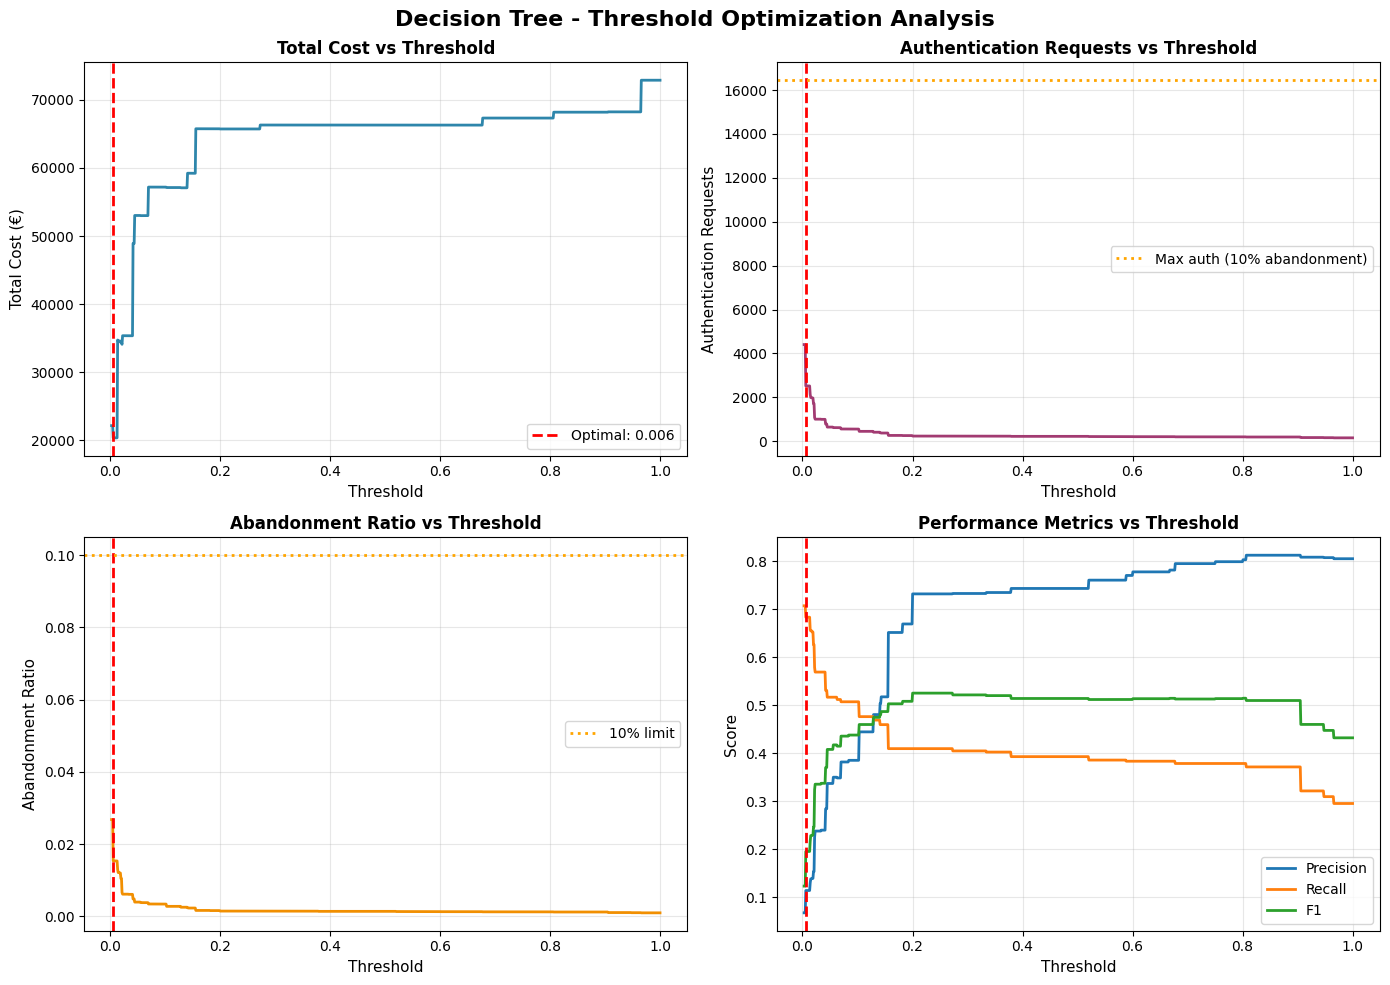

In [17]:
# Train Decision Tree
print("Training Decision Tree...")
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_tr, y_tr)
print("✅ Training complete\n")

# Evaluate with threshold sweep
dt_results = evaluate_model_with_threshold_sweep(
    dt, X_te, y_te, amounts_te=amt_te, model_type="sklearn", model_name="Decision Tree"
)

### 3. Random Forest


Training Random Forest...
✅ Training complete

✅ Training complete

RANDOM FOREST - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.019

Total cost: €10203.63
Authentication requested: 3262
Abandonment ratio: 0.0198 (1.98%)

Performance Metrics:
  Precision: 0.0996
  Recall:    0.7738
  F1 Score:  0.1765
  Accuracy:  0.9078

Cost Breakdown:
  Missed frauds cost:   €6941.63
  Authentication fee:   €3262.00
  Abandonment penalty:  €0.00
RANDOM FOREST - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.019

Total cost: €10203.63
Authentication requested: 3262
Abandonment ratio: 0.0198 (1.98%)

Performance Metrics:
  Precision: 0.0996
  Recall:    0.7738
  F1 Score:  0.1765
  Accuracy:  0.9078

Cost Breakdown:
  Missed frauds cost:   €6941.63
  Authentication fee:   €3262.00
  Abandonment penalty:  €0.00


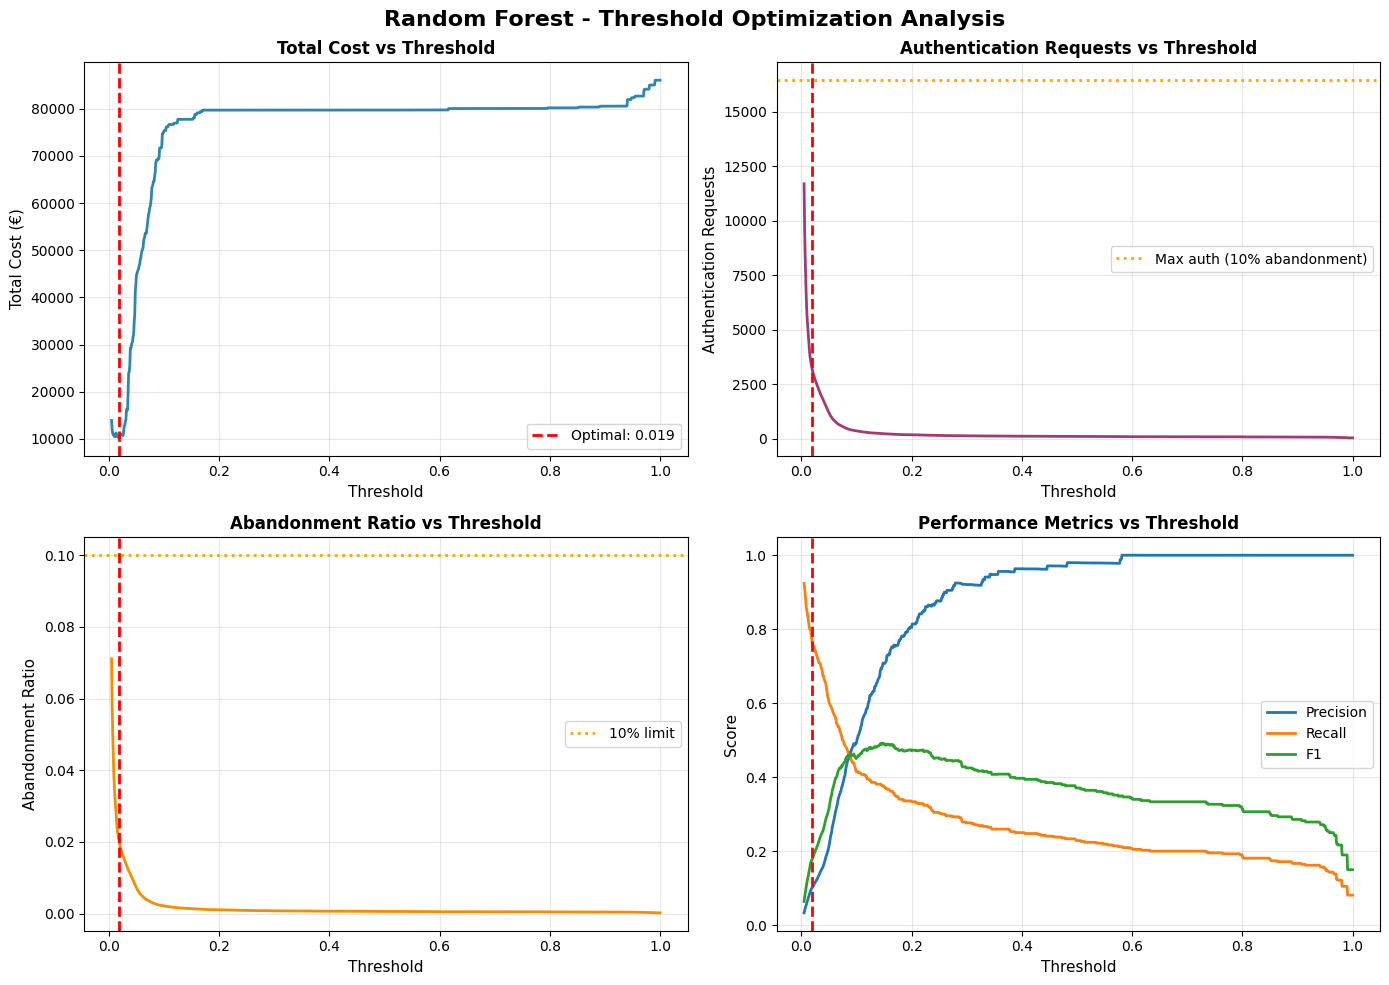

In [18]:
# Train Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_tr, y_tr)
print("✅ Training complete\n")

# Evaluate with threshold sweep
rf_results = evaluate_model_with_threshold_sweep(
    rf, X_te, y_te, amounts_te=amt_te, model_type="sklearn", model_name="Random Forest"
)

### 4. Gradient Boosting (XGBoost-style)


Training Gradient Boosting...
✅ Training complete

✅ Training complete

GRADIENT BOOSTING - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.011

Total cost: €10053.14
Authentication requested: 3451
Abandonment ratio: 0.0210 (2.10%)

Performance Metrics:
  Precision: 0.0974
  Recall:    0.8000
  F1 Score:  0.1736
  Accuracy:  0.9028

Cost Breakdown:
  Missed frauds cost:   €6602.14
  Authentication fee:   €3451.00
  Abandonment penalty:  €0.00
GRADIENT BOOSTING - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.011

Total cost: €10053.14
Authentication requested: 3451
Abandonment ratio: 0.0210 (2.10%)

Performance Metrics:
  Precision: 0.0974
  Recall:    0.8000
  F1 Score:  0.1736
  Accuracy:  0.9028

Cost Breakdown:
  Missed frauds cost:   €6602.14
  Authentication fee:   €3451.00
  Abandonment penalty:  €0.00


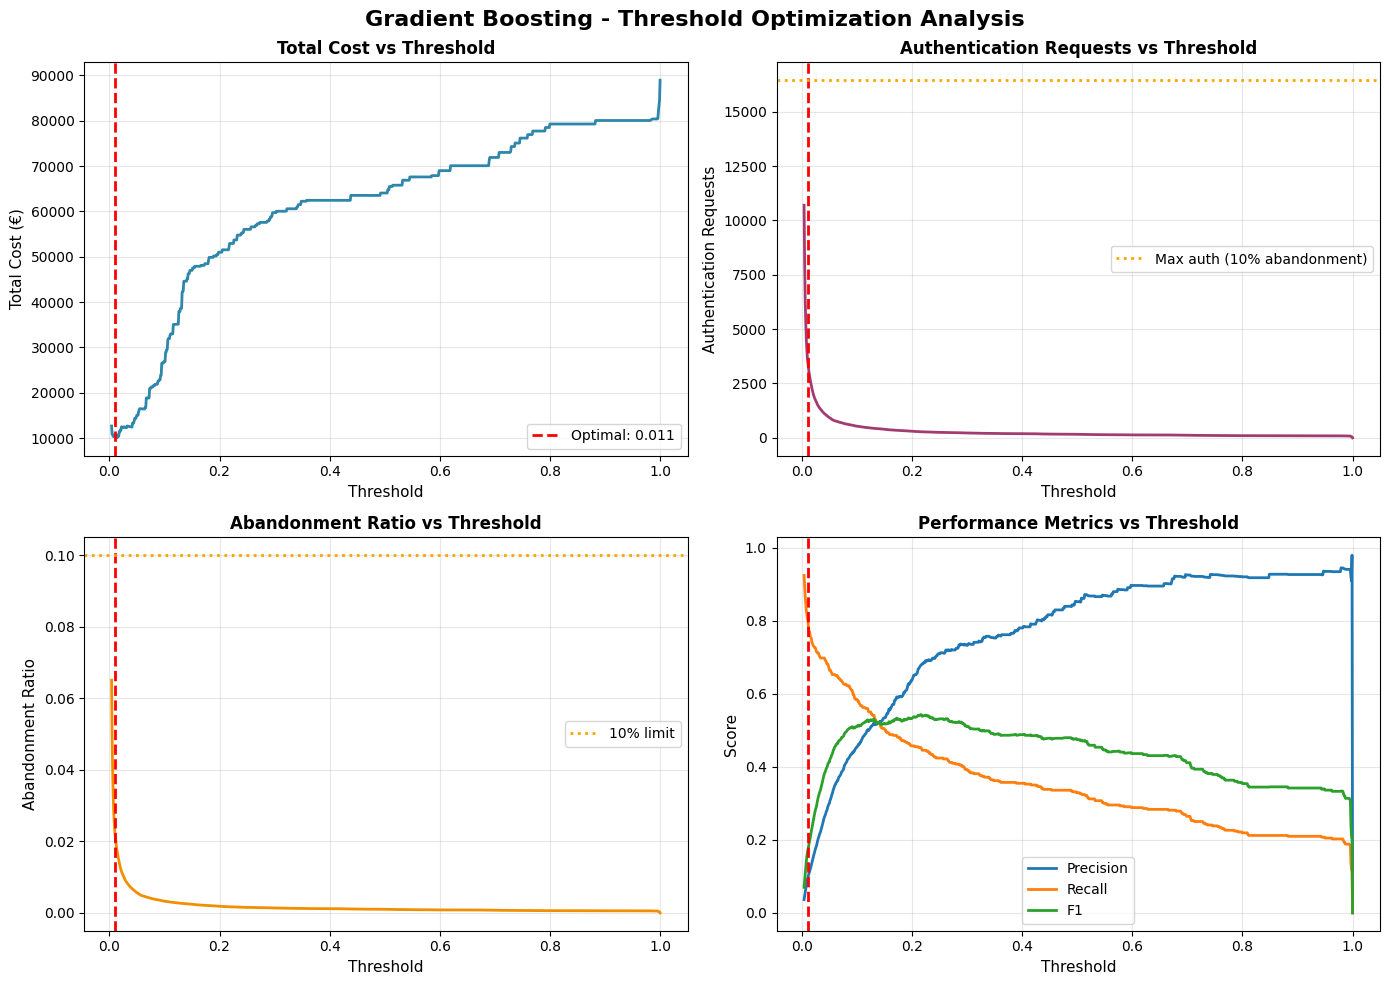

In [19]:
# Train Gradient Boosting
print("Training Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb.fit(X_tr, y_tr)
print("✅ Training complete\n")

# Evaluate with threshold sweep
gb_results = evaluate_model_with_threshold_sweep(
    gb,
    X_te,
    y_te,
    amounts_te=amt_te,
    model_type="sklearn",
    model_name="Gradient Boosting",
)

### 5. Neural Network (PyTorch)


Training Neural Network (hidden_dim=32, lr=0.001, epochs=50)...
Epoch 10/50  loss=0.0371  val_acc=0.9908
Epoch 10/50  loss=0.0371  val_acc=0.9908
Epoch 20/50  loss=0.0335  val_acc=0.9914
Epoch 20/50  loss=0.0335  val_acc=0.9914
Epoch 30/50  loss=0.0310  val_acc=0.9910
Epoch 30/50  loss=0.0310  val_acc=0.9910
Epoch 40/50  loss=0.0298  val_acc=0.9912
Epoch 40/50  loss=0.0298  val_acc=0.9912
Epoch 50/50  loss=0.0288  val_acc=0.9913
✅ Training complete. Best validation accuracy: 0.9915

Epoch 50/50  loss=0.0288  val_acc=0.9913
✅ Training complete. Best validation accuracy: 0.9915

NEURAL NETWORK - OPTIMAL THRESHOLD RESULTS
Best threshold: 0.011

Total cost: €7787.93
Authentication requested: 4997
Abandonment ratio: 0.0304 (3.04%)

Performance Metrics:
  Precision: 0.0760
  Recall:    0.9048
  F1 Score:  0.1403
  Accuracy:  0.8584

Cost Breakdown:
  Missed frauds cost:   €2790.93
  Authentication fee:   €4997.00
  Abandonment penalty:  €0.00
NEURAL NETWORK - OPTIMAL THRESHOLD RESULTS
Best t

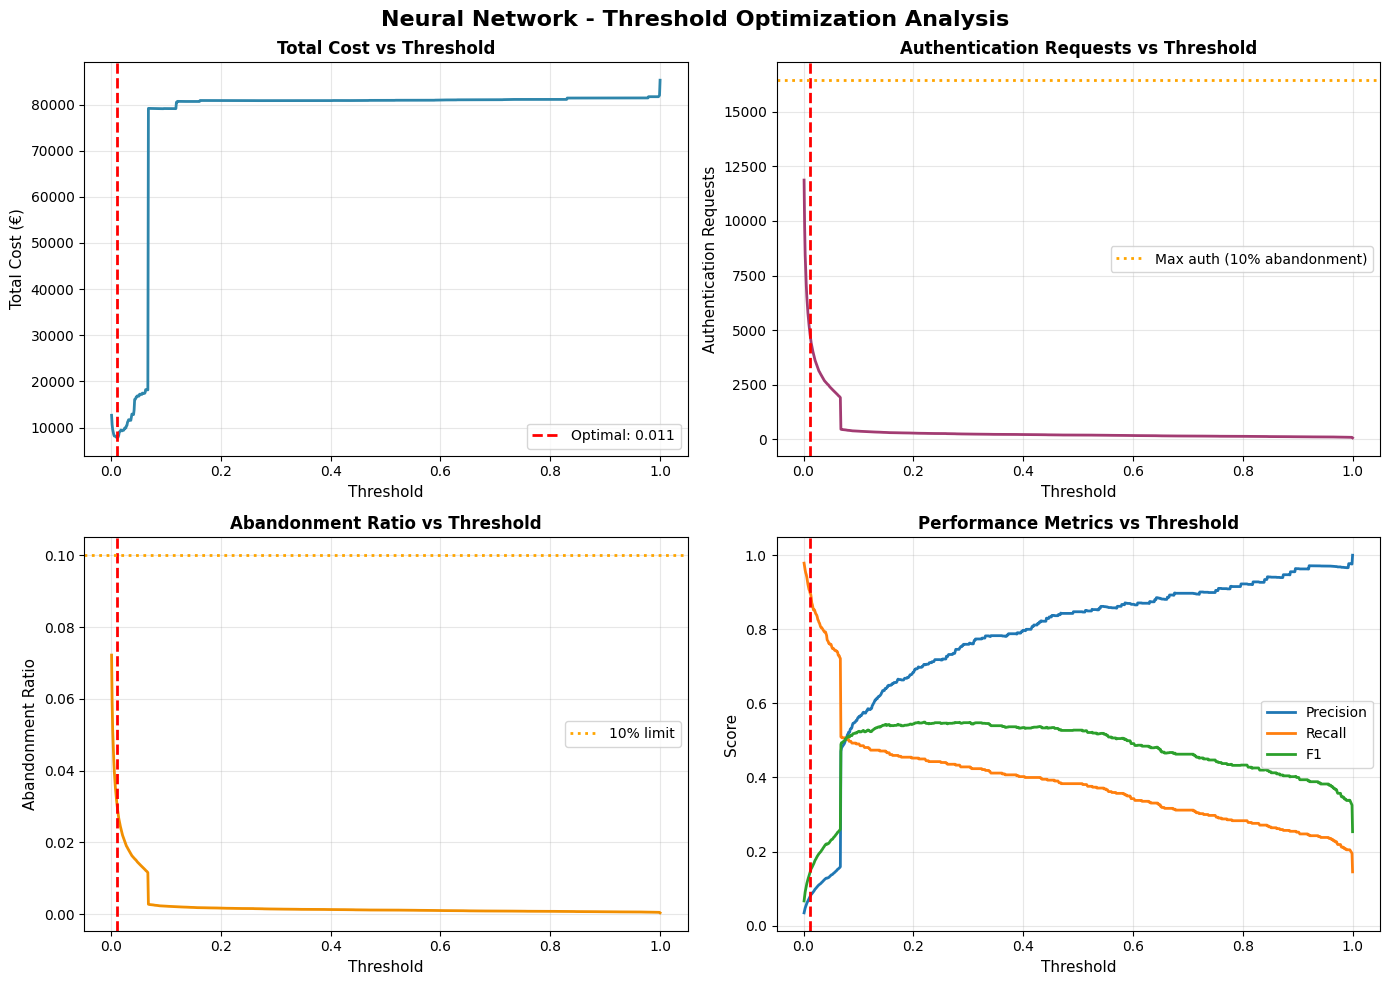

In [20]:
# Train Neural Network
nn_model = train_pytorch_model(
    X_tr, y_tr, X_va, y_va, hidden_dim=32, lr=1e-3, epochs=50
)

# Evaluate with threshold sweep
nn_results = evaluate_model_with_threshold_sweep(
    nn_model,
    X_te,
    y_te,
    amounts_te=amt_te,
    model_type="pytorch",
    model_name="Neural Network",
)

### 6. Neural Network with Custom Cost Loss


In [21]:
# Define Custom Loss Function
class ExpectedCostLoss(nn.Module):
    """
    Custom loss function that minimizes total business cost.
    """

    def __init__(
        self, abandonment_limit=0.1, user_lazy_factor=0.2, penalty_per_percent=10000
    ):
        super().__init__()
        self.limit = abandonment_limit
        self.lazy_factor = user_lazy_factor
        # 10,000 EUR penalty for every 1% (0.01) means we multiply by 1,000,000
        # Example: 0.11 - 0.10 = 0.01 * 1,000,000 = 10,000
        self.penalty_scaler = penalty_per_percent * 100

    def forward(self, logits, targets, amounts):
        """
        logits:  (batch_size, 1) Raw outputs
        targets: (batch_size, )  0 for Legit, 1 for Fraud
        amounts: (batch_size, )  Transaction values in EUR
        """
        # 1. Get Probabilities
        probs = torch.sigmoid(logits).squeeze()

        # 2. Authentication Cost
        # We pay ~1 EUR for every high probability assignment
        auth_cost = probs * 1.0

        # 3. Missed Fraud Cost
        # If target=1 and prob=0.1, we miss 0.9 * Amount
        missed_fraud_cost = targets * (1 - probs) * amounts

        # 4. Abandonment Penalty (Global Batch Constraint)
        avg_auth_rate = probs.mean()
        current_abandon_rate = avg_auth_rate * self.lazy_factor

        # ReLU handles the "cliff": if rate < limit, penalty is 0
        excess_abandonment = nn.functional.relu(current_abandon_rate - self.limit)
        abandonment_penalty = excess_abandonment * self.penalty_scaler

        # 5. Total Loss
        # We average per-transaction costs and add the global penalty
        total_loss = (auth_cost + missed_fraud_cost).mean() + abandonment_penalty

        return total_loss


# Define Cost-Optimized Neural Network Architecture
class CostOptimizedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # Output 1 scalar (logit)
        )

    def forward(self, x):
        return self.net(x)


def train_cost_optimized_model(
    X_tr,
    y_tr,
    amounts_tr,
    X_va,
    y_va,
    amounts_va,
    hidden_dim=32,
    lr=1e-3,
    epochs=200,
    batch_size=512,
):
    """Train a PyTorch neural network with custom cost-sensitive loss."""
    # Convert to tensors
    X_train_t = torch.tensor(X_tr, dtype=torch.float32)
    y_train_t = torch.tensor(y_tr, dtype=torch.float32)
    amt_train_t = torch.tensor(amounts_tr, dtype=torch.float32)

    X_val_t = torch.tensor(X_va, dtype=torch.float32)
    y_val_t = torch.tensor(y_va, dtype=torch.float32)
    amt_val_t = torch.tensor(amounts_va, dtype=torch.float32)

    # Initialize model
    model = CostOptimizedNN(X_tr.shape[1], hidden_dim)
    loss_fn = ExpectedCostLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_cost = float("inf")
    best_weights = None
    N = X_train_t.shape[0]

    print(
        f"Training Cost-Optimized Neural Network (hidden_dim={hidden_dim}, lr={lr}, epochs={epochs})..."
    )

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]
            ab = amt_train_t[idx]

            logits = model(xb)
            loss = loss_fn(logits, yb, ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / N

        # Validation cost
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_cost = loss_fn(val_logits, y_val_t, amt_val_t).item()

        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_weights = {
                k: v.detach().clone() for k, v in model.state_dict().items()
            }

        if (epoch + 1) % 20 == 0:
            print(
                f"Epoch {epoch+1:03d}/{epochs}  train_loss={avg_loss:.4f}  val_cost={val_cost:.2f}"
            )

    # Restore best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)

    print(f"✅ Training complete. Best validation cost: {best_val_cost:.2f}\n")
    return model

Training Cost-Optimized Neural Network (hidden_dim=32, lr=0.001, epochs=200)...
Epoch 020/200  train_loss=2.6044  val_cost=2.72
Epoch 020/200  train_loss=2.6044  val_cost=2.72
Epoch 040/200  train_loss=2.5864  val_cost=2.70
Epoch 040/200  train_loss=2.5864  val_cost=2.70
Epoch 060/200  train_loss=2.3944  val_cost=2.51
Epoch 060/200  train_loss=2.3944  val_cost=2.51
Epoch 080/200  train_loss=2.3711  val_cost=2.49
Epoch 080/200  train_loss=2.3711  val_cost=2.49
Epoch 100/200  train_loss=2.3679  val_cost=2.48
Epoch 100/200  train_loss=2.3679  val_cost=2.48
Epoch 120/200  train_loss=2.3673  val_cost=2.48
Epoch 120/200  train_loss=2.3673  val_cost=2.48
Epoch 140/200  train_loss=2.3673  val_cost=2.48
Epoch 140/200  train_loss=2.3673  val_cost=2.48
Epoch 160/200  train_loss=2.3186  val_cost=2.40
Epoch 160/200  train_loss=2.3186  val_cost=2.40
Epoch 180/200  train_loss=0.2191  val_cost=0.23
Epoch 180/200  train_loss=0.2191  val_cost=0.23
Epoch 200/200  train_loss=0.2231  val_cost=0.23
✅ Traini

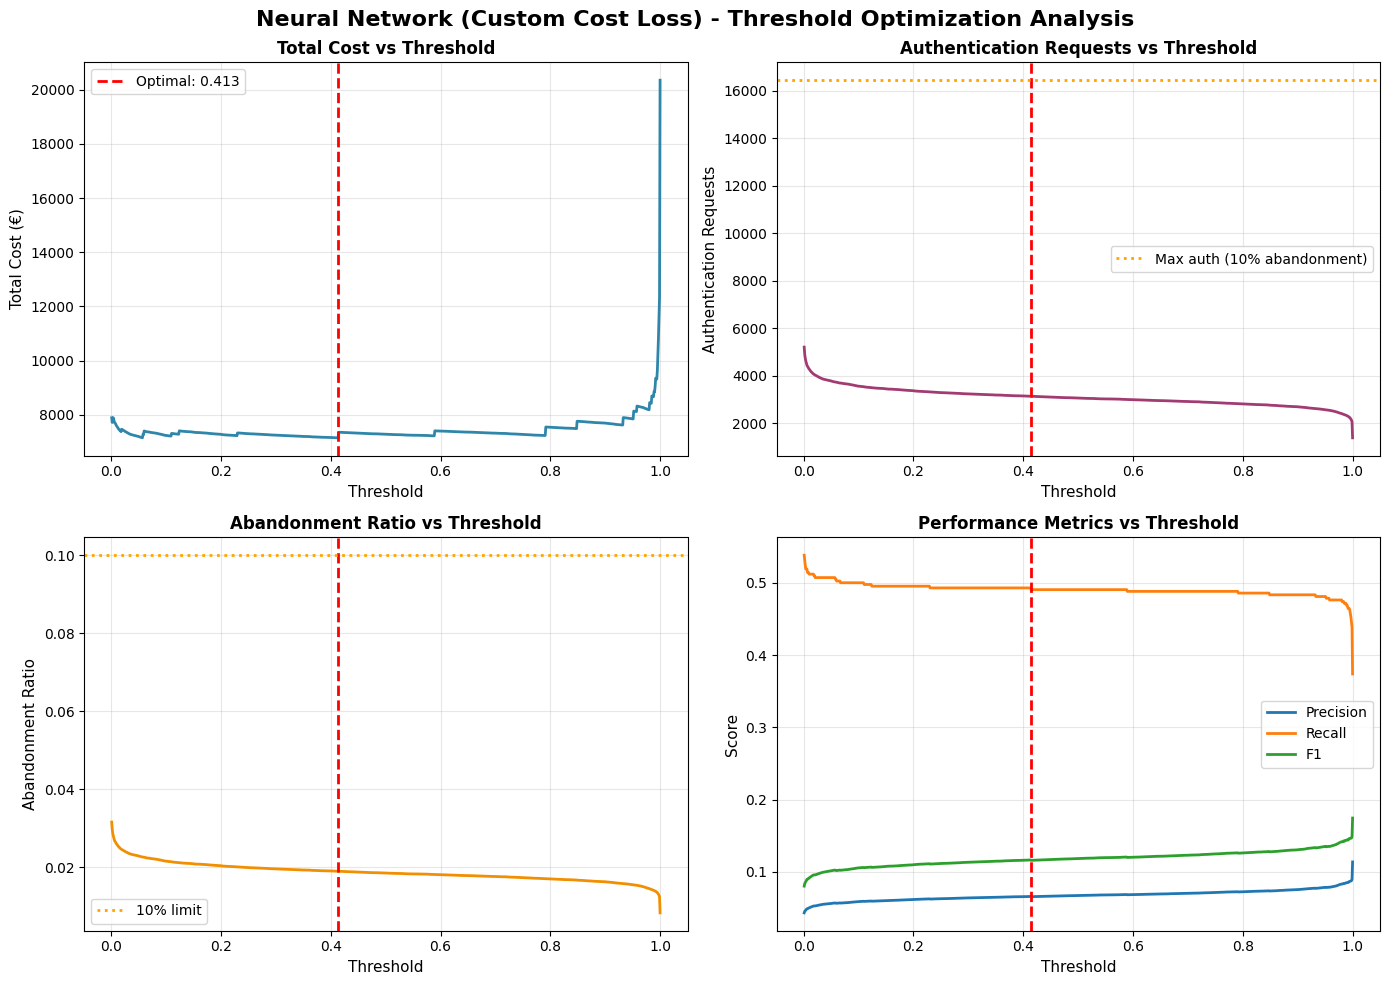

In [22]:
# Train Cost-Optimized Neural Network
cost_nn_model = train_cost_optimized_model(
    X_tr, y_tr, amt_tr, X_va, y_va, amt_va, hidden_dim=32, lr=1e-3, epochs=200
)


# Create a wrapper for evaluation that converts binary output to probabilities
class CostOptimizedNNWrapper:
    """Wrapper to make CostOptimizedNN compatible with evaluation function."""

    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).squeeze().numpy()
        # Return in sklearn format: [prob_class_0, prob_class_1]
        return np.column_stack([1 - probs, probs])


cost_nn_wrapper = CostOptimizedNNWrapper(cost_nn_model)

# Evaluate with threshold sweep
cost_nn_results = evaluate_model_with_threshold_sweep(
    cost_nn_wrapper,
    X_te,
    y_te,
    amounts_te=amt_te,
    model_type="sklearn",
    model_name="Neural Network (Custom Cost Loss)",
)

## Compare All Models


In [23]:
# Compile results from all models
model_comparison = []

for name, results in [
    ("Logistic Regression", log_reg_results),
    ("Decision Tree", dt_results),
    ("Random Forest", rf_results),
    ("Gradient Boosting", gb_results),
    ("Neural Network", nn_results),
    ("NN (Custom Cost Loss)", cost_nn_results),
]:
    if results is not None:
        best = results["best_result"]
        model_comparison.append(
            {
                "Model": name,
                "Optimal Threshold": f"{best['threshold']:.3f}",
                "Total Cost (€)": f"{best['total_cost']:.2f}",
                "Precision": f"{best['precision']:.4f}",
                "Recall": f"{best['recall']:.4f}",
                "F1 Score": f"{best['f1']:.4f}",
                "Auth Requests": int(best["auth_requested"]),
                "Abandonment %": f"{best['abandonment_ratio']*100:.2f}%",
            }
        )

comparison_df = pd.DataFrame(model_comparison)
print("\n" + "=" * 120)
print("MODEL COMPARISON SUMMARY")
print("=" * 120)
print(comparison_df.to_string(index=False))
print("=" * 120)


MODEL COMPARISON SUMMARY
                Model Optimal Threshold Total Cost (€) Precision Recall F1 Score  Auth Requests Abandonment %
  Logistic Regression             0.006       32083.47    0.0246 0.8857   0.0478          15149         9.21%
        Decision Tree             0.006       20374.63    0.1139 0.6833   0.1953           2519         1.53%
        Random Forest             0.019       10203.63    0.0996 0.7738   0.1765           3262         1.98%
    Gradient Boosting             0.011       10053.14    0.0974 0.8000   0.1736           3451         2.10%
       Neural Network             0.011        7787.93    0.0760 0.9048   0.1403           4997         3.04%
NN (Custom Cost Loss)             0.413        7145.49    0.0661 0.4929   0.1166           3132         1.90%


## Visualize Model Comparison


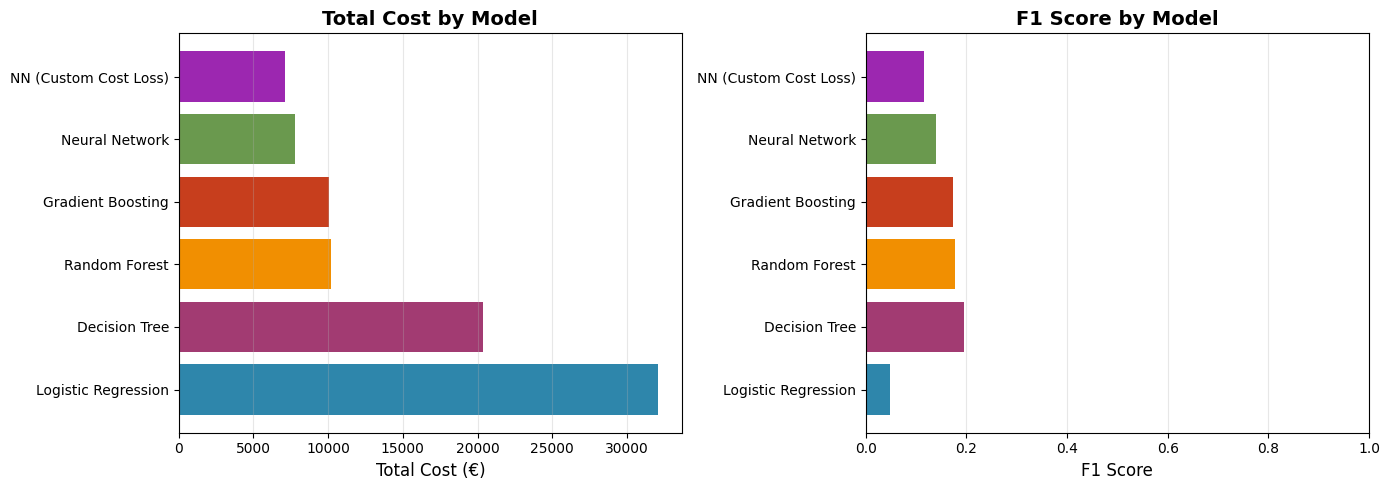

In [24]:
# Extract numeric values for plotting
models = [row["Model"] for row in model_comparison]
costs = [float(row["Total Cost (€)"].replace(",", "")) for row in model_comparison]
f1_scores = [float(row["F1 Score"]) for row in model_comparison]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total Cost Comparison
colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#6A994E", "#9C27B0"]
ax1.barh(models, costs, color=colors[: len(models)])
ax1.set_xlabel("Total Cost (€)", fontsize=12)
ax1.set_title("Total Cost by Model", fontsize=14, fontweight="bold")
ax1.grid(axis="x", alpha=0.3)

# Plot 2: F1 Score Comparison
ax2.barh(models, f1_scores, color=colors[: len(models)])
ax2.set_xlabel("F1 Score", fontsize=12)
ax2.set_title("F1 Score by Model", fontsize=14, fontweight="bold")
ax2.set_xlim(0, 1)
ax2.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()